In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d'
run_name = 'sarsa_easy7b'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Learning of the 3d kite with sarsa

In [4]:
## ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.001 # sec
env_params['ep_length'] = 100 # sec
env_params['decision_time'] = 0.5 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_phi'] = 0 # rad
env_params['init_dphi'] = 0 # rad
# attack angles
env_params['alphas'] = [8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
# bank angles
#env_params['banks'] = np.deg2rad([-8,-6,-4,-2,-1,0,1,2,4,6,8])
env_params['banks'] = np.deg2rad([0])
env_params['init_bank'] = int(len(env_params['banks'])/2) # index
print(env_params['init_bank'])
# wind
env_params['wind_type'] = 'const'
env_params['v_wind_x'] = 10 # m/sec
env_params['v_wind_y'] = 0 # m/sec
env_params['v_wind_z'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'sarsa' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 100000 # Number of training steps
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])

alg_params['traj_points'] = 1000
#alg_params['init_q_path'] = '../data/' + system_name + '/sarsa0/best_quality.txt' # Policy prior, comment for flat policy
alg_params['init_quals'] = env_params['v_wind_x']*env_params['ep_length']/5
# Learning rate
alg_params['lr0'] = 0.2
alg_params['lrc'] = 2000000
alg_params['lr_expn'] = 1
alg_params['lr_burn'] = 20000000
# Exploration parameter
alg_params['eps0'] = 0.1
alg_params['epsc'] = 1000000
alg_params['eps_expn'] = 1
alg_params['eps_burn'] = 10000000

0
Dynamical steps:  2000000000.0
Dynamical time, in seconds:  1000000


In [5]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, 'param_env.txt')
ut.write_params(alg_params, data_dir, 'param_alg.txt')

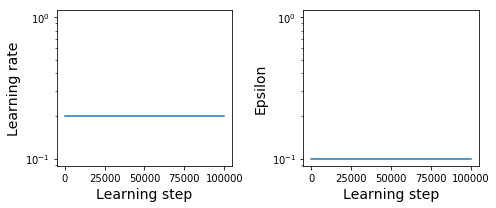

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Learning rate', fontsize=14)
ax1.set_yscale('log')
xs = np.linspace(0, alg_params['n_steps'], alg_params['traj_points'])
lr = [ut.p_law_burn(x, alg_params['lr_burn'], alg_params['lr_expn'], alg_params['lr0'], alg_params['lrc']) for x in xs]
ax1.plot(xs, lr)

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Epsilon', fontsize=14)
ax2.set_yscale('log')
eps = [ut.p_law_burn(x, alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc']) for x in xs]
ax2.plot(xs, eps)

plt.tight_layout()
plt.savefig(plot_dir+'lr.png', dpi=200)

In [7]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
q_traj, s_labels, a_labels = ut.read_2d_traj(data_dir+'/quality_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')

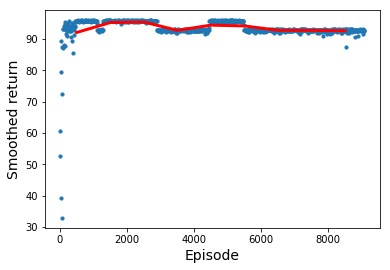

In [8]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj[:,0], 10)
plt.scatter(x,y,s=10)
x, y = ut.smooth_traj(r_traj[:,0], 1000)
plt.plot(x,y, color='red', lw=3)

plt.savefig(plot_dir+'return.png', dpi=200)

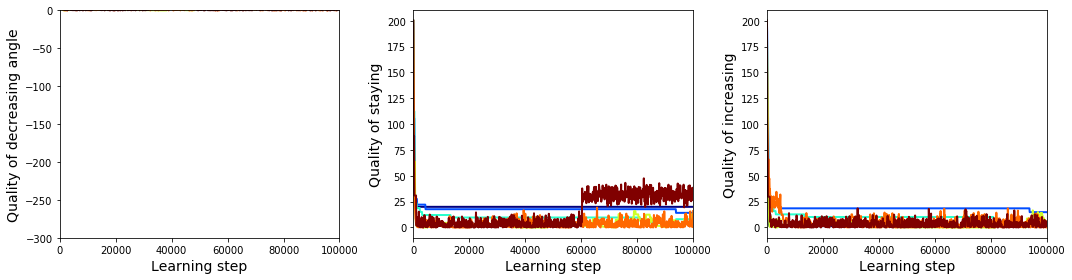

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(q_traj[0])))
states = range(0,len(q_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Quality of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
ax1.set_ylim([-300,0])
for k in states:
    ax1.plot(xs, q_traj[:,k,0], c=colors[k], label=s_labels[k], lw=2)
#ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Quality of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax2.plot(xs, q_traj[:,k,1], c=colors[k], label=s_labels[k], lw=2)

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Quality of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax3.plot(xs, q_traj[:,k,2], c=colors[k], label=s_labels[k], lw=2)
    
plt.tight_layout()
plt.savefig(plot_dir+'qualities.png', dpi=200)

In [37]:
q_traj

array([], dtype=float64)